In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# generating a synthetic input


In [2]:
import numpy as np

In [3]:
import pyNN
pyNN

<module 'pyNN' from '/usr/local/lib/python3.7/site-packages/pyNN/__init__.py'>

In [4]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution, NumpyRNG

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/usr/local/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [5]:
# === Define parameters ========================================================
dt         = 0.1           # (ms)
simtime    = 10000.0        # (ms)

N_inputs = 360
t_starts = np.linspace(50, 9800, 250)

In [6]:
def vonmises(N_inputs, theta=.50, B=.61803):
    return np.exp((np.cos(2*np.pi*(np.linspace(0, 1, N_inputs)-theta))-1)/B**2)

def get_latency(spike_times, current, tau=50., t_start=100.):
    N_inputs = current.size
    if spike_times is None:
        spike_times = []
        for i_input in range(N_inputs):
            spike_times.append([])
            
    for i_input in range(N_inputs):
        if current[i_input] > 1:
            spike_time = t_start + tau * np.log(1/(1 - 1/current[i_input]))
            spike_times[i_input].append(spike_time)
    return spike_times


def celebrini(N_inputs, A=2.2, theta=.50, B=.61803, tau=50., t_start=t_starts, verbose=False):
    # https://www.cambridge.org/core/journals/visual-neuroscience/article/dynamics-of-orientation-coding-in-area-v1-of-the-awake-primate/906FA662AD71B432EB6D4F10795A397A
    
    current = A * vonmises(N_inputs, theta=theta, B=B)
    if verbose : print('current.max()', current.max())

    spike_times = None
    for t_start_ in t_start:
        spike_times = get_latency(spike_times, current, tau=tau, t_start=t_start_)
    if verbose : print('spike_times', spike_times)
    #spike_source = sim.Population(N_inputs, sim.SpikeSourceArray(spike_times=spike_times))
    spike_source = sim.SpikeSourceArray(spike_times=spike_times)
    
    return spike_source

spike_source = celebrini(N_inputs, verbose=False)

In [7]:

# === Build the network ========================================================
sim.setup(timestep=dt)
spike_source = celebrini(N_inputs, verbose=False)
spike_in = sim.Population(N_inputs, spike_source)
spike_in.record('spikes')

# === Run simulation ===========================================================

sim.run(simtime)
sim.end()
    

In [8]:
sts = spike_in.get_data().segments[0].spiketrains
st = sts[0]

In [9]:
st

SpikeTrain
annotations: {'source_population': 'population0',
  'source_id': 363,
  'source_index': 0}

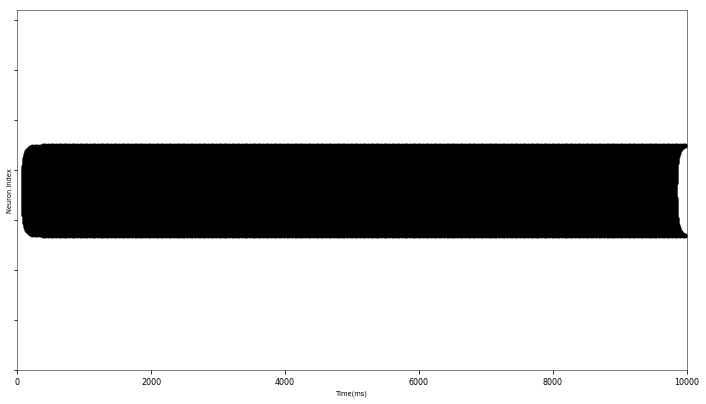

In [10]:
#plotting the short way with PyNN multi panel lib
from pyNN.utility.plotting import Figure, Panel
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,8))
Figure(Panel(spike_in.get_data().segments[0].spiketrains, xlabel = 'Time(ms)', xticks = True, lw = 2))

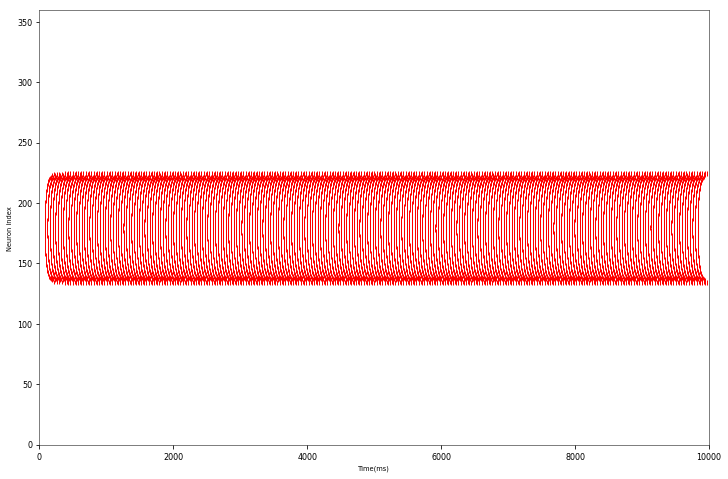

In [11]:

def plot_spiketrains(spiketrains, simtime=None, fig=None, ax=None, 
                     color='r', markersize=4, verbose=False):
    """
    Plot all spike trains in a Segment in a raster plot.
    
    marker size is in points.
    
    """
    if fig is None:
        fig, ax = plt.subplots(figsize = (12,8))
    if ax is None:
        ax = fig.subplot(1, 1)
    
    if simtime is None:
        from quantities import ms
        simtime = spiketrains[0].t_stop / ms
        
    ax.set_xlim(0, simtime)
    if verbose: print('spiketrains[0].t_stop', spiketrains[0].t_stop)
    from sys import maxsize
    max_index = 0
    min_index = maxsize
    for spiketrain in spiketrains:
        ax.plot(spiketrain,
                 np.ones_like(spiketrain) * spiketrain.annotations['source_index'],
                 '|', c=color, markersize=markersize)
        max_index = max(max_index, spiketrain.annotations['source_index'])
        min_index = min(min_index, spiketrain.annotations['source_index'])
    ax.set_ylabel("Neuron index")
    ax.set_xlabel('Time(ms)')
    
    ax.set_ylim(-0.5 + min_index, max_index + 0.5)
    return fig, ax

spiketrains = spike_in.get_data().segments[0].spiketrains
fig, ax = plot_spiketrains(spiketrains, color='r')


A 0.8705505632961241
A 1.252664438624128
A 1.8025009252216606
A 2.5936791093020197
A 3.73213196614723
A 5.370290011121053
A 7.727490631398766
A 11.119345758738698
A 16.0


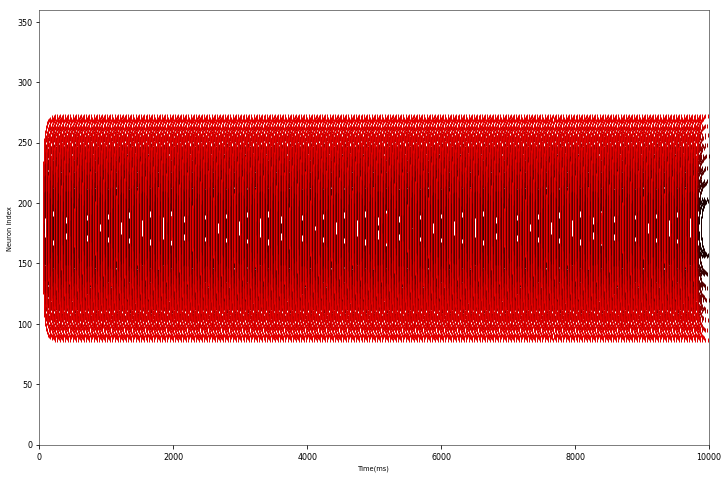

In [12]:
fig, ax = plt.subplots(figsize = (12,8))
N_scan = 9
for i_scan, A in enumerate(np.logspace(-.1, 2, N_scan, base=4)):
    sim.setup(timestep=dt)
    print('A', A)
    spike_source = celebrini(N_inputs, A=A)
    spike_in = sim.Population(N_inputs, spike_source)
    spike_in.record('spikes')

    # === Run simulation ===========================================================

    sim.run(simtime)
    sim.end()
    spiketrains = spike_in.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(spiketrains, color=(i_scan/N_scan, 0, 0), fig=fig, ax=ax)
    

B 0.25
B 0.313166109656032
B 0.3922920489483753
B 0.4914102992726256
B 0.6155722066724582
B 0.7711054127039704
B 0.9659363289248457
B 1.2099940892192926
B 1.515716566510398


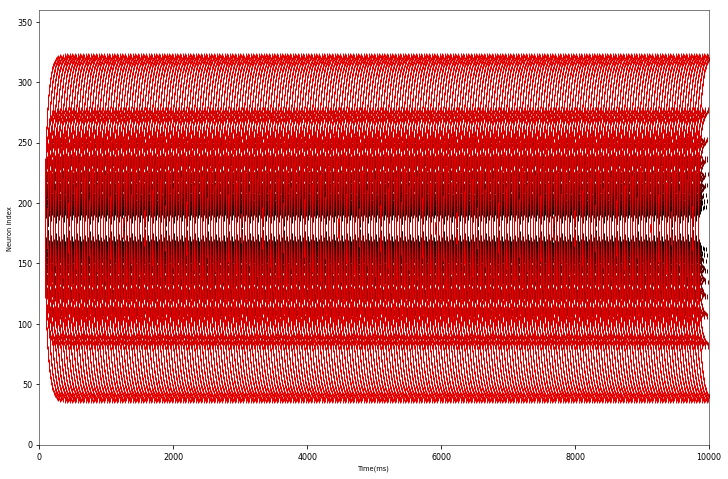

In [13]:
fig, ax = plt.subplots(figsize = (12,8))
for i_scan, B in enumerate(np.logspace(-1, .3, N_scan, base=4)):
    sim.setup(timestep=dt)
    print('B', B)
    spike_source = celebrini(N_inputs, B=B, verbose=False)
    spike_in = sim.Population(N_inputs, spike_source)
    spike_in.record('spikes')

    # === Run simulation ===========================================================
    sim.run(simtime)
    sim.end()
    spiketrains = spike_in.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(spiketrains, color=(i_scan/N_scan, 0, 0), fig=fig, ax=ax)


theta 0.0
theta 0.125
theta 0.25
theta 0.375
theta 0.5
theta 0.625
theta 0.75
theta 0.875
theta 1.0


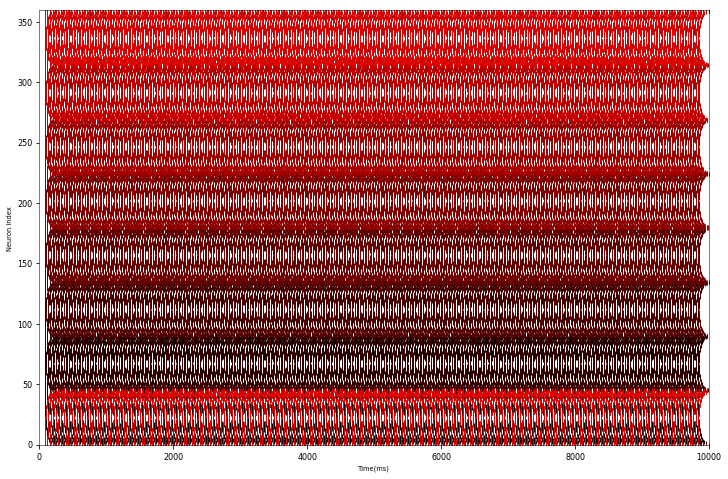

In [14]:
#def celebrini(N_inputs, A=2.2, tau=50., theta=.50, B=.61803, t_start=100., verbose=False):
fig, ax = plt.subplots(figsize = (12,8))
for i_scan, theta in enumerate(np.linspace(0, 1, N_scan)):
    sim.setup(timestep=dt)
    print('theta', theta)
    spike_source = celebrini(N_inputs, theta=theta, verbose=False)
    spike_in = sim.Population(N_inputs, spike_source)
    spike_in.record('spikes')

    # === Run simulation ===========================================================
    sim.run(simtime)
    sim.end()
    spiketrains = spike_in.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(spiketrains, color=(i_scan/N_scan, 0, 0), fig=fig, ax=ax)


t_start 10.0
t_start 96.25
t_start 182.5
t_start 268.75
t_start 355.0
t_start 441.25
t_start 527.5
t_start 613.75
t_start 700.0


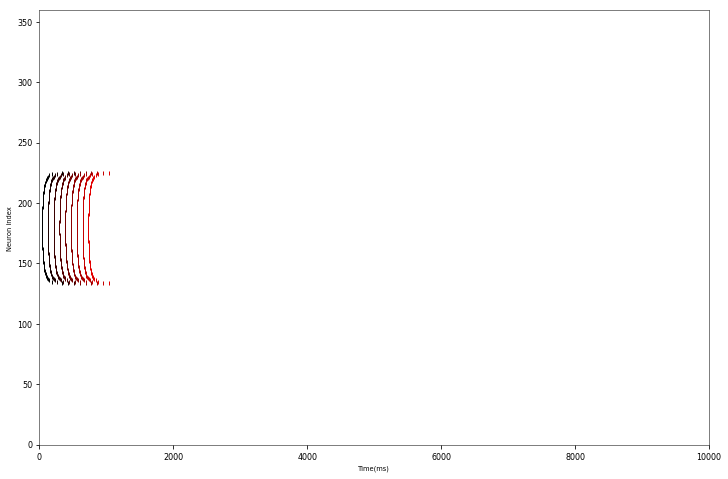

In [15]:
#def celebrini(N_inputs, A=2.2, tau=50., theta=.50, B=.61803, t_start=100., verbose=False):
fig, ax = plt.subplots(figsize = (12,8))
for i_scan, t_start in enumerate(np.linspace(10, 700, N_scan)):
    sim.setup(timestep=dt)
    print('t_start', t_start)
    spike_source = celebrini(N_inputs, t_start=[t_start], verbose=False)
    spike_in = sim.Population(N_inputs, spike_source)
    spike_in.record('spikes')

    # === Run simulation ===========================================================
    sim.run(simtime)
    sim.end()
    spiketrains = spike_in.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(spiketrains, color=(i_scan/N_scan, 0, 0), fig=fig, ax=ax)


## feeding that input to a range of orientation selective cells

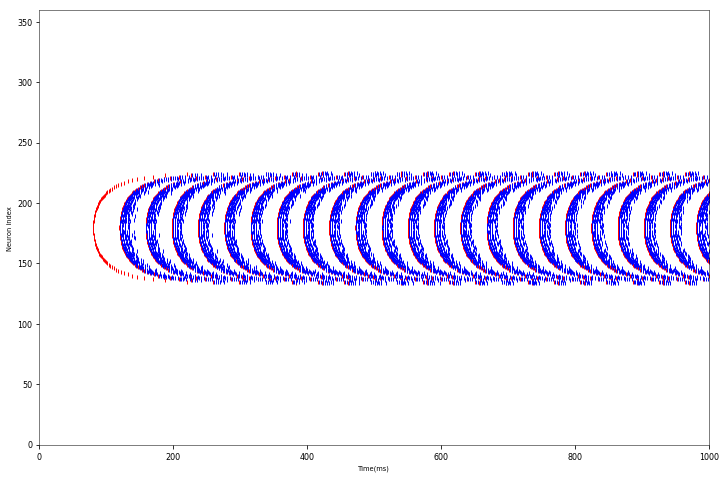

In [16]:

def LSD_neuron(weights, delays, t_starts=t_starts, fig=None, ax=None, sat=1, verbose=False):
    # === Define parameters ========================================================
    dt         = 0.1           # (ms)
    simtime    = 1000.0        # (ms)
    #With PyNN, the model is defined by CellType classes, whose models work on any simulator
    refraction_time = RandomDistribution('uniform', [2.0, 3.0], rng = NumpyRNG(seed = 1234))
    thalamocort_params = {'cm':0.25, 'tau_m':20.0, 'v_rest':-60, 'v_thresh':-50, 'tau_refrac':refraction_time, 
                       'v_reset':-60,
                      'v_spike':-50.0, 'a':1.0, 'b':0.005, 'tau_w':600, 'delta_T':2.5, 'tau_syn_E':5.0, 'e_rev_E':0.0,
                      'tau_syn_I':10.0, 'e_rev_I':-80}
    #thalamocort_params.update({'a':20, 'b': 0.0})

    # === Build the network ========================================================
    sim.reset()
    sim.setup(timestep=dt)
    # N_inputs, A=2.2, tau=50., theta=.50, B=.61803, t_start=100., verbose=False
    spike_source = celebrini(N_inputs, t_start=t_starts, verbose=False)
    spike_input = sim.Population(N_inputs, spike_source)
    spike_input.record('spikes')

    thalamocort_cell = sim.EIF_cond_exp_isfa_ista(**thalamocort_params)
    tc_cells = sim.Population(N_inputs, thalamocort_cell)
    tc_cells.record('spikes')

    #Synapses type
    delayed_synapses = sim.StaticSynapse()
    #connectivity using the projection method
    connections = sim.Projection(spike_input, tc_cells,
                                        connector=sim.AllToAllConnector(),
                                        synapse_type=delayed_synapses,
                                        receptor_type='excitatory',
                                        label="excitatory connections")

    connections.set(weight = weights, delay = delays)

    # === Run simulation ===========================================================
    sim.run(simtime)
    sim.end()
    
    if fig is None:
        fig, ax = plt.subplots(figsize = (12,8))
    if ax is None:
        ax = fig.subplot(1, 1)
    sts_in = spike_input.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(sts_in, color=(sat, 0, 0), fig=fig, ax=ax)
    if verbose: print('sts_in', [list(st.as_array()) for st in sts_in])
    sts_out = tc_cells.get_data().segments[0].spiketrains
    if verbose: print('sts_out', [list(st.as_array()) for st in sts_out])
    fig, ax = plot_spiketrains(sts_out, color=(0, 0, sat), fig=fig, ax=ax)
    output = dict(spike_input=spike_input, tc_cells=tc_cells)
    return fig, ax, output

weight_0, delay_0 = 0.2, 40
weights = weight_0 * np.diag(np.ones(N_inputs))
delays = delay_0 * np.ones((N_inputs, N_inputs)) #np.diag(np.ones(N_inputs))
fig, ax, output = LSD_neuron(weights, delays)
    

In [17]:
output['tc_cells']

Population(360, EIF_cond_exp_isfa_ista(<parameters>), structure=Line(dx=1.0, x0=0.0, y=0.0, z=0.0), label='population38')

In [18]:
pop = output['tc_cells']

In [19]:
pop.all_cells

array([725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737,
       738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750,
       751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763,
       764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776,
       777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789,
       790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802,
       803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815,
       816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828,
       829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841,
       842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854,
       855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867,
       868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880,
       881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893,
       894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 90

In [20]:
aa = output['tc_cells'].get_spike_counts()
np.array([aa[i] for i in pop.all_cells])

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  65,  81,  75,  88,  85,  84,  92,  80,  81,
        88,  96,  89,  88,  93,  88,  91,  81,  88,  92,  94,  90,  90,
        90,  83,  91,  91,  95,  91,  84,  89,  84,  89,  92,  92,  90,
        84,  92,  93,  93,  90,  95,  92,  93,  90,  92,  92,  9

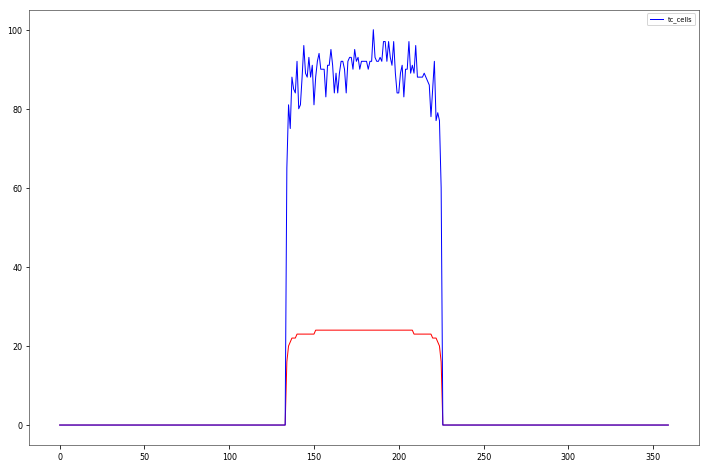

In [21]:
def mean_rate_per_neuron(pop):
    sc = pop.get_spike_counts()
    return np.array([sc[i] for i in pop.all_cells])

def histogram(output, fig=None, ax=None, sat=1, lw=1, label='tc_cells'):
    if fig is None:
        fig, ax = plt.subplots(figsize = (12,8))
    if ax is None:
        ax = fig.subplot(1, 1)
    ax.plot(mean_rate_per_neuron(output['spike_input']), color=(sat, 0, 0), lw=lw)
    ax.plot(mean_rate_per_neuron(output['tc_cells']), color=(0, 0, sat), lw=lw, label=label)
    return fig, ax
fig, ax = histogram(output)
ax.legend(loc='best');

## Testing different base weights:

weight_0_ 0.03333333333333333
weight_0_ 0.052169486002442915
weight_0_ 0.08164965809277261
weight_0_ 0.1277886208492545
weight_0_ 0.2
weight_0_ 0.3130169160146575
weight_0_ 0.4898979485566356
weight_0_ 0.766731725095527
weight_0_ 1.2000000000000002


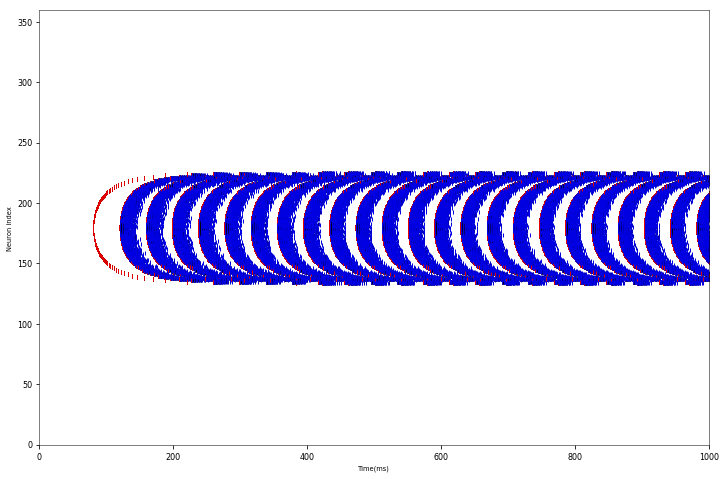

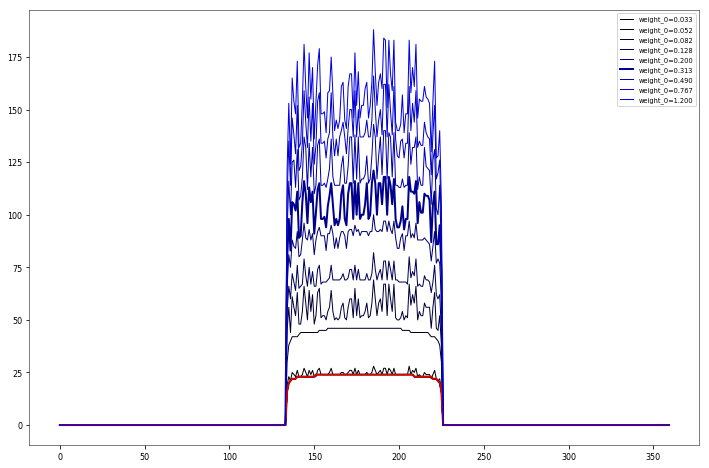

In [22]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))
for i_scan, weight_0_ in enumerate(weight_0*np.logspace(-1, 1, N_scan, base=6)):
    print('weight_0_', weight_0_)
    label = 'weight_0=%.3f' % weight_0_
    weights = weight_0_ * np.diag(np.ones(N_inputs))
    delays = delay_0 * np.ones((N_inputs, N_inputs)) #np.diag(np.ones(N_inputs))
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2+1 else 1)    
hax.legend(loc='best');    

delay_0_ 20.0
delay_0_ 23.78414230005442
delay_0_ 28.284271247461902
delay_0_ 33.63585661014858
delay_0_ 40.0
delay_0_ 47.56828460010884
delay_0_ 56.568542494923804
delay_0_ 67.27171322029716
delay_0_ 80.0


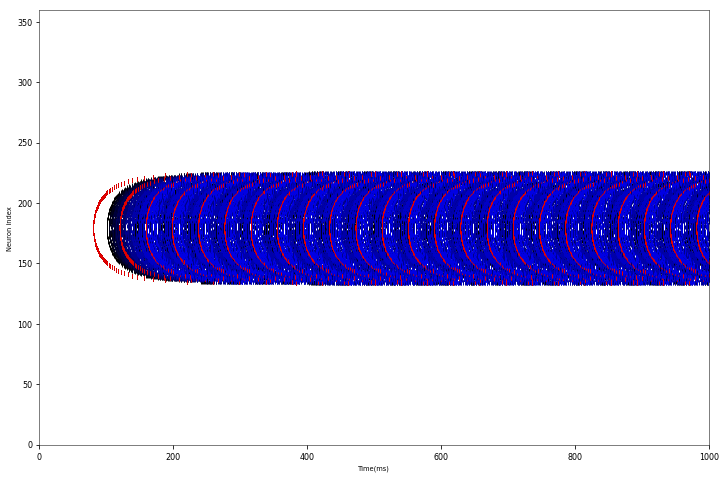

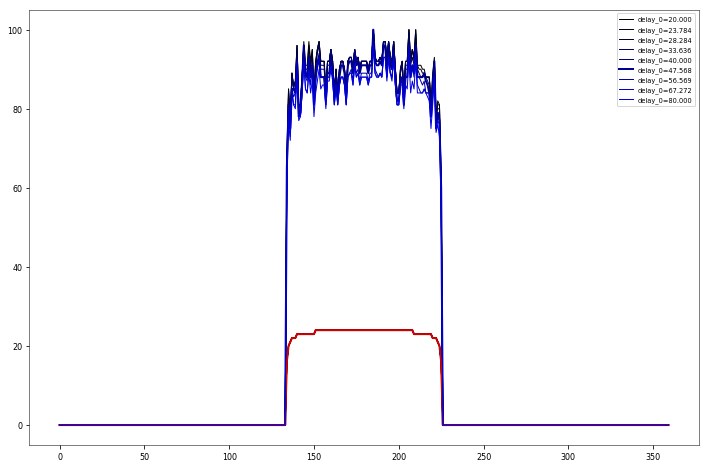

In [23]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))
for i_scan, delay_0_ in enumerate(delay_0*np.logspace(-1, 1, N_scan, base=2)):
    print('delay_0_', delay_0_)
    label = 'delay_0=%.3f' % delay_0_
    weights = weight_0 * np.diag(np.ones(N_inputs))
    delays = delay_0_ * np.ones((N_inputs, N_inputs)) #np.diag(np.ones(N_inputs))
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2+1 else 1)    
hax.legend(loc='best');      

delay_0_ 40
delay_0_ 140


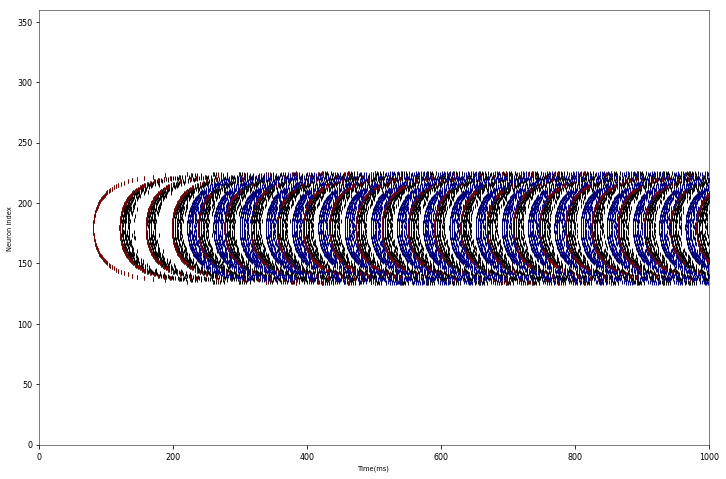

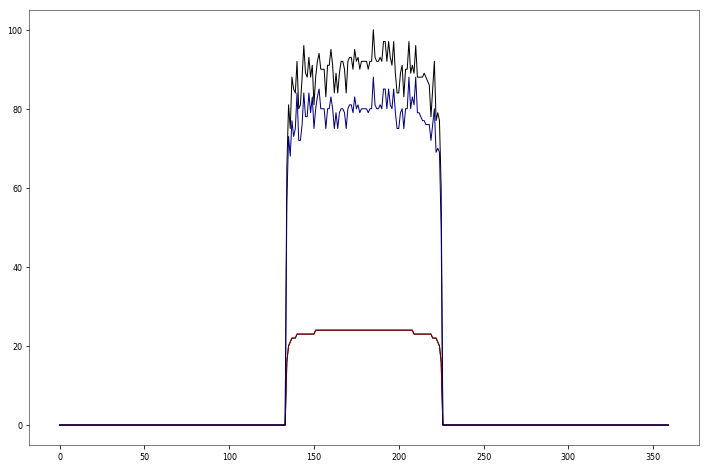

In [24]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))
for i_scan, delay_0_ in enumerate([40, 140]):
    print('delay_0_', delay_0_)
    weights = weight_0 * np.diag(np.ones(N_inputs))
    delays = delay_0_ * np.ones((N_inputs, N_inputs)) #np.diag(np.ones(N_inputs))
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/2)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/2)    


DONE: undestood why the whole input raster also moves = one has to set weights to the projection object not to the synapses

## Testing different tuning curves on the weights

In [25]:
from scipy.linalg import toeplitz
toeplitz?

AssertionError: wrong rule def 'keywords'

In [ ]:
weight_0, vonmises(N_inputs)

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))
weight_0 = 5e-2
for i_scan, weight_0_ in enumerate(weight_0*np.logspace(-1, 1, N_scan, base=6)):
    print('weight_0_', weight_0_)
    label = 'weight_0=%.3f' % weight_0_
    tf = vonmises(N_inputs, theta=.0)
    tf /= tf.sum()
    weights = weight_0_ * toeplitz(tf)
    delays = delay_0 * np.ones((N_inputs, N_inputs))
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2+1 else 1)    
hax.legend(loc='best');   

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))
for i_scan, B_ in enumerate(B*np.logspace(-1, 1, N_scan, base=4)):
    print('B_', B_)
    label = 'B=%.3f' % B_    
    tf = vonmises(N_inputs, theta=.0, B=B_)
    tf /= tf.sum()
    weights = weight_0_ * toeplitz(tf)
    delays = delay_0 * np.ones((N_inputs, N_inputs))
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2+1 else 1)    
hax.legend(loc='best');    

## Testing different tuning curves on the weights and delays

Some heuristics:

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))
for i_scan, weight_0_ in enumerate(weight_0*np.logspace(-1, 1, N_scan, base=6)):
    print('weight_0_', weight_0_)
    label = 'weight_0=%.3f' % weight_0_
    tf = vonmises(N_inputs, theta=.0, B=B)
    tf /= tf.sum()
    weights = weight_0_ * toeplitz(tf)
    delays = delay_0_ * (1 + toeplitz(vonmises(N_inputs)))
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=.5+.5*i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2+1 else 1)    
hax.legend(loc='best');    

In [ ]:

A_est = 2.3
B_est = 0.61803
tau_est = 30 

current = A_est * vonmises(N_inputs, theta=0., B=B_est)
print('current.max()', current.max())
spike_times = np.array(get_latency(None, current, tau=tau_est, t_start=0.))
print('spike_times.max()', np.max(spike_times))

In [ ]:
def get_delay_line(N_inputs, A_est = 2.3, B_est = 0.61803, tau_est = 30 ):
    current = A_est * vonmises(N_inputs, theta=0., B=B_est)
    spike_times = get_latency(None, current, tau=tau_est, t_start=0.)
    
    spike_times_, mask = np.zeros(N_inputs), np.ones(N_inputs)
    for i in range(N_inputs):
        if len(spike_times[i]) > 0: 
            spike_times_[i] = spike_times[i][0]
        else:
            spike_times_[i] = np.nan
    
    tau_max = np.nanmax(spike_times_)
    delay_line = tau_max - spike_times_
    return delay_line
plt.plot(get_delay_line(N_inputs))

In [ ]:
np.where?

In [ ]:
delay_line = get_delay_line(N_inputs)
np.isnan(delay_line)

In [ ]:
np.where(np.isnan(delay_line), 0, delay_line)

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))

weight_0 = 0.01

for i_scan, weight_0_ in enumerate(weight_0*np.logspace(-.3, 1, N_scan, base=6)):
    print('weight_0_', weight_0_)
    label = 'weight_0=%.3f' % weight_0_

    delay_line = get_delay_line(N_inputs)
    
    delays = delay_0 + toeplitz(np.where(np.isnan(delay_line), 0, delay_line))

    tf = vonmises(N_inputs, theta=.0, B=B_est)
    tf = np.where(np.isnan(delay_line), 0, tf)
    tf /= tf.sum()
    weights = weight_0_ * toeplitz(tf)

    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2+1 else 1)    
hax.legend(loc='best');    

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))

for i_scan, B_ in enumerate(B*np.logspace(-1, 1, N_scan, base=4)):
    print('B_', B_)
    label = 'B=%.3f' % B_

    delay_line = get_delay_line(N_inputs, B_est=B_)
    delays = delay_0 + toeplitz(np.where(np.isnan(delay_line), 0, delay_line))

    tf = vonmises(N_inputs, theta=.0, B=B_est)
    tf = np.where(np.isnan(delay_line), 0, tf)
    tf /= tf.sum()
    weights = weight_0_ * toeplitz(tf)

    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2+1 else 1)    
hax.legend(loc='best');    